<a href="https://colab.research.google.com/github/hokkebu/test/blob/main/gentextas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imput.txtに学習させたいテキストをコピペして使う。

 1文字以上Hokke.png		 NSI_cleaned_noTitle.txt
 2文字以上Hokke.png		'NSI_cleaned_noTitle.txt のコピー'
 HokkeWordsList1charOver.txt	 NSI_cleaned.txt
 HokkeWordsListOver2chars.txt	 NSI_cleaned_withTitleNoDankan.txt
 input.txt			 NSI_cleaned_withTitle.txt
 keras_lstm.py			 NSI_nonQTnonRB.txt
 loss.png			 NSI_nonQTnonRB_WordsRank.txt
 mini.gdoc			 output_20200509_104934.log
 NichirenShimpitsuIbun.txt	 over3mojiWordRank.txt
 NotRankWords.txt		 test.py
 NSI_1_ページ表記なし.txt	 wordcloud2.png
 NSI_2_ページ表記なし.txt	 wordcloud.png
 NSI_cleaned_noTitle_mini.gdoc	 wordcloud_test.py
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Size of text:  10235
Total chars : 703
size of sentences :  3399
size of next_chars :  3399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learnin

--------------------------------------------------
繰り返し回数:  1
27/27 [==============================] - 2s 14ms/step - loss: 5.1513
--------------------------------------------------
繰り返し回数:  2
27/27 [==============================] - 0s 10ms/step - loss: 4.6679
--------------------------------------------------
繰り返し回数:  3
27/27 [==============================] - 0s 9ms/step - loss: 4.1774
--------------------------------------------------
繰り返し回数:  4
27/27 [==============================] - 0s 9ms/step - loss: 3.7287
--------------------------------------------------
繰り返し回数:  5
27/27 [==============================] - 0s 9ms/step - loss: 3.3031
--------------------------------------------------
繰り返し回数:  6
27/27 [==============================] - 0s 9ms/step - loss: 2.9233
--------------------------------------------------
繰り返し回数:  7
27/27 [==============================] - 0s 9ms/step - loss: 2.5885
--------------------------------------------------
繰り返し回数:  8
27/27 [===================

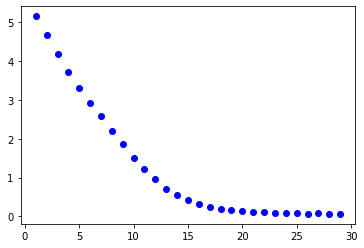

In [23]:
# モデル実装

from keras.models import Sequential,load_model
from keras.layers import Dense, Activation, LSTM
#from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
# from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import matplotlib.pyplot as plt 


# データ取得
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/10_BD/Nichiren/IbunBunseki/input.txt"
bindata = open(path, "rb").read()
text = bindata.decode("utf-8")

print("Size of text: ",len(text)) # テキスト中の単語と句読点（トークン）の合計数を求める
chars = sorted(list(set(text))) # 文字の種類（set(text)）をリスト化してソート（記号、あいうえお順）する
print("Total chars :",len(chars))


# 40文字の次の1文字を学習させる. 3文字ずつずらして40文字と1文字というセットを作る
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text)-maxlen, step): 
  #3文字ずつずらした40文字text[i:i+maxlenのリスト
  sentences.append(text[i:i+maxlen]) 
  #40文字の次の1文字text[i+maxlen]のリスト
  next_chars.append(text[i+maxlen]) 
print("size of sentences : ", len(sentences))
print("size of next_chars : ", len(next_chars))


#辞書を作成する
char_indices = dict((c,i) for i,c in enumerate(chars)) #keyが文字で、valueが番号
indices_char = dict((i,c) for i,c in enumerate(chars)) #keyが番号で、valueが文字


# テキストのベクトル化
# 配列の全要素をFalseで初期化
X = np.zeros((len(sentences),maxlen,len(chars)),dtype=np.bool)
y = np.zeros((len(sentences),len(chars)),dtype=np.bool)

# 番号と40文字リストのループ
for i, sentence in enumerate(sentences): 
  # 番号と40文字の各文字のループ
  for t ,char in enumerate(sentence): 
    X[i,t,char_indices[char]] = 1 # char_indices[char] = 文字に該当する辞書char_indicesの番号
  y[i,char_indices[next_chars[i]]] = 1 # 次の1文字に該当する辞書char_indicesの番号


# LSTMを使ったモデル作成
model = Sequential() 
model.add(LSTM(128, input_shape=(maxlen,len(chars))))
model.add(Dense(len(chars)))
model.add(Activation("softmax"))
optimizer = RMSprop(lr = 0.01)
model.compile(loss="categorical_crossentropy",optimizer=optimizer)


def sample(preds, temperature=1.0):
  # numpyで用いられるarray形式に変換
  preds = np.asarray(preds).astype("float64") 

  # 1 / temperature * log(preds) を計算  log(preds ** (1 / temperature)) 
  # temperatureは平滑化のための係数で、値が大きいほど、確率分布が平になる (つまり言語モデルによる確率分布が重要視されなくなる)
  preds = np.log(preds) / temperature       

  # exp_preds = preds ** (1 / temperature)を計算　expを取るのは確率の定義である値が0以上であるようにするため
  exp_preds = np.exp(preds)   

  # predsを確率分布として計算
  preds = exp_preds / np.sum(exp_preds)       

  # predsに従って文字を一つサンプリング　probsはサンプリングされた文字インデックスのみ1、それ以外は0となるarrayとなる
  probs = np.random.multinomial(1, preds, 1)   

  # argmaxを取ることによって、サンプリングされた文字インデックス
  return np.argmax(probs)                      



# モデルの学習
num = 30
for iteration in range(1,num):
  print("-"*50)
  print("繰り返し回数: ",iteration)

  # モデルの学習
  history = model.fit(X, y, batch_size=128, epochs=1)
  loss = history.history["loss"]

  # グラフ表示
  plt.plot(iteration,  loss, "bo", label = "Training loss" )

  # テキストの何文字目から取得するかをランダムに選択
  # start_index = random.randint(0, len(text)-maxlen-1)
  # 生成文のスタート
  ## start_index = 241 # 241は本文のスタート部分
  start_index = 0


# 予測
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print()
    print("-----diversity", diversity)

    generated =""

    # 40文字の文章
    sentence = text[start_index: start_index + maxlen ]
    generated += sentence
    print("-----Seedを生成しました: ")
    print(sentence)
    
    sys.stdout.write(generated)

    # 40文字のあとの、次の400文字を予測
    for i in range(400):

      # sentenceのベクトル化
      x = np.zeros((1,maxlen,len(chars)))
      for t,char in enumerate(sentence):
          x[0, t, char_indices[char]] = 1

      # 次の文字を予測
      preds = model.predict(x, verbose =9)[0]
      # 次の1文字のインデックス
      next_index = sample(preds, diversity)
      # 次の1文字
      next_char = indices_char[next_index]
      # 次の1文字を追加する
      generated += next_char

      # 2文字目からに、次の1文字を追加した40字（1文字ずらした40字）
      sentence = sentence[1:] + next_char
      
      # 次の1文字をコンソールに出力
      sys.stdout.write(next_char)
      sys.stdout.flush()
    print()


model.save('souseki_model.h5')
file = open('sousekigentext.txt','w+',encoding='utf-8').write(generated)